In [26]:
import os
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from PIL import Image
import cv2
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import matplotlib.image as mImg
import pandas as pd
from tqdm import tqdm
import argparse
%matplotlib inline

In [27]:
parser = argparse.ArgumentParser()

parser.add_argument("--GauSxy", type=int, default=3)
parser.add_argument("--BilSxy", type=int, default=80)
parser.add_argument("--BilSrgb", type=int, default=13)

args = parser.parse_args()

_StoreAction(option_strings=['--BilSrgb'], dest='BilSrgb', nargs=None, const=None, default=13, type=<class 'int'>, choices=None, help=None, metavar=None)

In [28]:
test_path = './test'
ann_path = './result'
save_path = './crf_output'

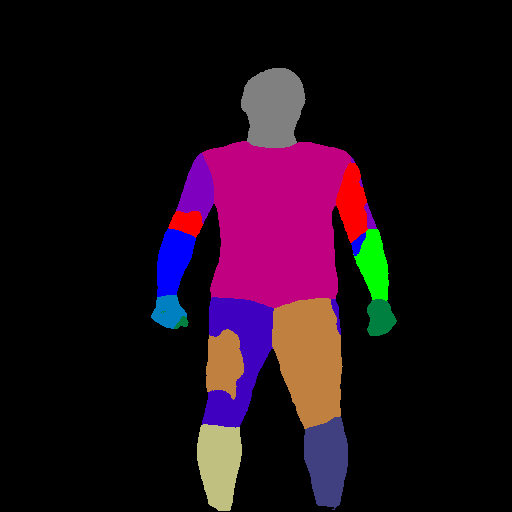

(116, (512, 512))

In [29]:
randnum = np.random.randint(0, 399)
image_sample = Image.open(os.path.join(ann_path, str(randnum).zfill(4)+'.png'))
image_sample.show()
randnum, image_sample.size

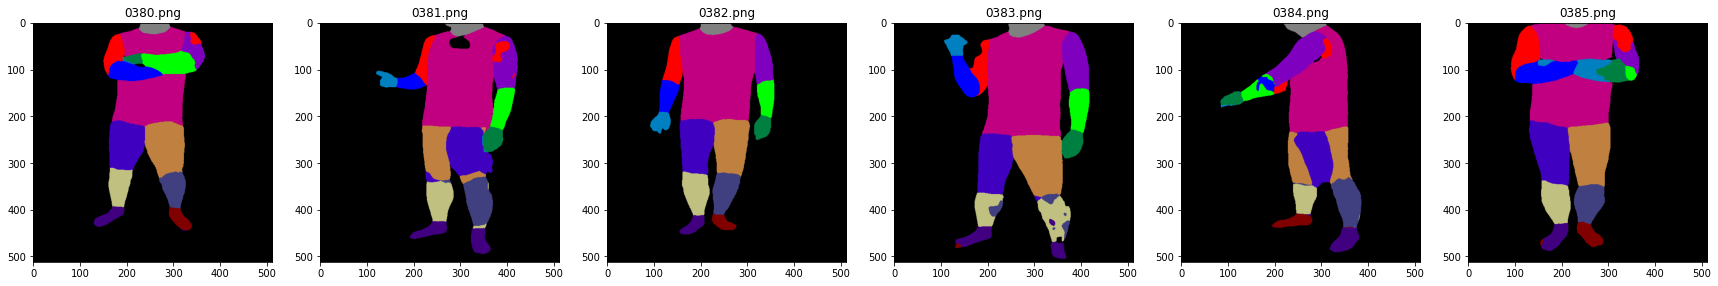

In [31]:
"""
reading and decoding the submission 

"""

j = np.random.randint(0, 394)
plt.figure(figsize=(30,15))
plt.subplots_adjust(bottom=0.2, top=0.8, hspace=0.2)  #adjust this to change vertical and horiz. spacings..

# Visualizing the predicted outputs
for k in range(6):
    plt.subplot(1, 6, k+1)
    readImg = mImg.imread(os.path.join(ann_path, str(j+k).zfill(4)+'.png'))
    plt.imshow(readImg)
    plt.title(str(j+k).zfill(4)+'.png')


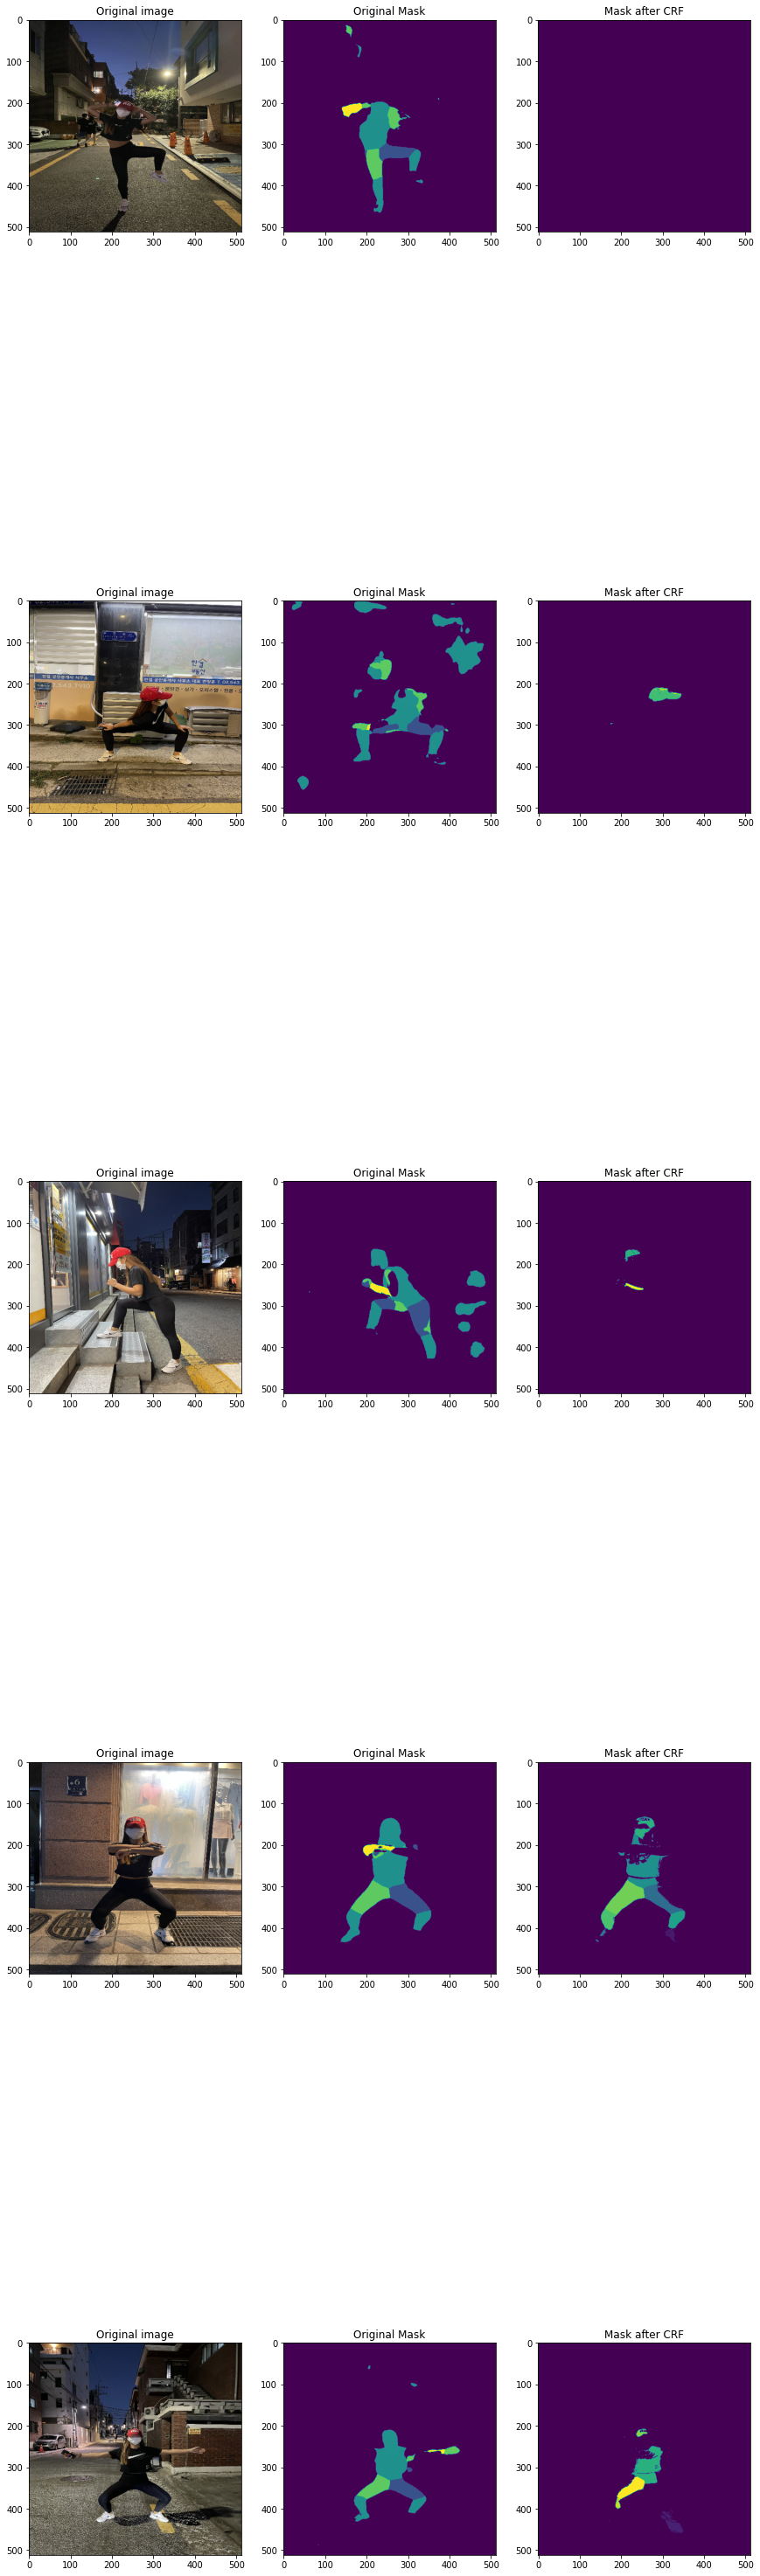

In [32]:
"""
visualizing the effect of applying CRF

"""

nImgs = 5
i = 0 # np.random.randint(390)
plt.figure(figsize=(20,60))
plt.subplots_adjust(wspace=0.2,hspace=0.1)  #adjust this to change vertical and horiz. spacings..

for j in range(1, nImgs+1):
    # # apply CRF
    img = imread(os.path.join(test_path, str(i+j).zfill(4)+'.jpg'))
    img = cv2.resize(img, (512, 512))
    anno_rgb = imread(os.path.join(ann_path, str(i+j).zfill(4)+'.png')).astype(np.uint32)
    anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)

    colors, labels = np.unique(anno_lbl, return_inverse=True)

    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16

    n_labels = len(set(labels.flat)) #- int(HAS_UNK)

    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                            compat=10,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    crf_output = MAP.reshape((img.shape[0],img.shape[1]))

    # show
    plt.subplot(nImgs,4,4*j-3)
    plt.imshow(img)
    plt.title('Original image')
    plt.subplot(nImgs,4,4*j-2)
    plt.imshow(anno_lbl) 
    plt.title('Original Mask')
    plt.subplot(nImgs,4,4*j-1)
    plt.imshow(crf_output) 
    plt.title('Mask after CRF')

In [34]:
"""
Applying CRF on the predicted mask 

"""
os.makedirs(save_path, exist_ok=True)

for i in tqdm(range(400)):
    # # apply CRF
    img = imread(os.path.join(test_path, str(i).zfill(4)+'.jpg'))
    img = cv2.resize(img, (512, 512))
    anno_rgb = imread(os.path.join(ann_path, str(i).zfill(4)+'.png')).astype(np.uint32)
    anno_lbl = anno_rgb[:,:,0] + (anno_rgb[:,:,1] << 8) + (anno_rgb[:,:,2] << 16)

    colors, labels = np.unique(anno_lbl, return_inverse=True)

    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16

    n_labels = len(set(labels.flat)) #- int(HAS_UNK)

    # Example using the DenseCRF2D code
    d = dcrf.DenseCRF2D(img.shape[1], img.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
    d.addPairwiseBilateral(sxy=(80, 80), srgb=(13, 13, 13), rgbim=img,
                            compat=10,
                            kernel=dcrf.DIAG_KERNEL,
                            normalization=dcrf.NORMALIZE_SYMMETRIC)

    Q = d.inference(45)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)
    MAP = colorize[MAP, :]

    crf_output = MAP.reshape((img.shape[0],img.shape[1], 3))

    imsave(os.path.join(save_path, str(i).zfill(4)+'.png'), crf_output)

    

  0%|          | 0/400 [00:00<?, ?it/s]/tmp/ipykernel_20450/3447876446.py:48: UserWarning: ./crf_output/0000.png is a low contrast image
  imsave(os.path.join(save_path, str(i).zfill(4)+'.png'), crf_output)
  0%|          | 1/400 [00:06<40:22,  6.07s/it]/tmp/ipykernel_20450/3447876446.py:48: UserWarning: ./crf_output/0001.png is a low contrast image
  imsave(os.path.join(save_path, str(i).zfill(4)+'.png'), crf_output)
  0%|          | 2/400 [00:12<41:35,  6.27s/it]/tmp/ipykernel_20450/3447876446.py:48: UserWarning: ./crf_output/0002.png is a low contrast image
  imsave(os.path.join(save_path, str(i).zfill(4)+'.png'), crf_output)
  1%|          | 3/400 [00:18<42:11,  6.38s/it]/tmp/ipykernel_20450/3447876446.py:48: UserWarning: ./crf_output/0003.png is a low contrast image
  imsave(os.path.join(save_path, str(i).zfill(4)+'.png'), crf_output)
  3%|▎         | 11/400 [01:10<41:13,  6.36s/it]/tmp/ipykernel_20450/3447876446.py:48: UserWarning: ./crf_output/0011.png is a low contrast image
  